# Chapter8. 어텐션

In [1]:
from IPython.display import Image
import numpy as np

## 8.1 어텐션의 구조

어텐션이라는 메커니즘을 이용하면 seq2seq는 인간처럼 필요한 정보에만 주목할 수 있게 됨!

### 8.1.1 seq2seq의 문제점

- Encoder가 항상 고정 길이의 벡터를 출력하기 때문에 아무리 긴 문장이 입력되더라도 항상 똑같은 길이의 벡터에 밀어넣어야 함
- 그렇게 되면 필요한 정보가 벡터에 다 담기지 못하는 문제 발생

### 8.1.2 Encoder 개선

Encoder 출력의 길이를 입력 문장의 길이에 따라 바꿔주자!

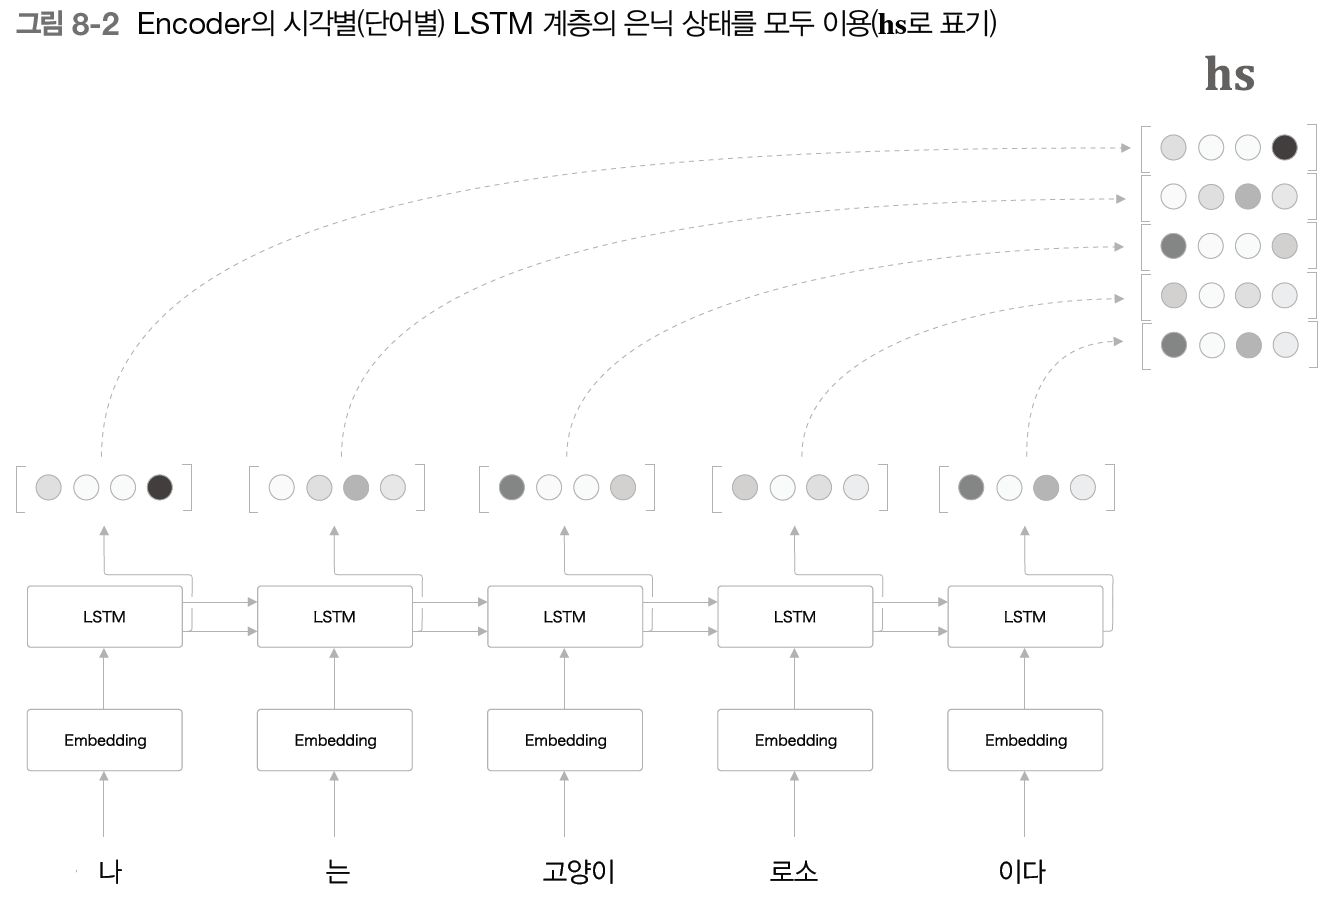

In [3]:
Image("image/fig 8-2.png")

- 입력된 단어와 같은 수의 벡터를 얻음으로서 '하나의 고정 길이 벡터'라는 제약으로부터 해방
- 각각의 벡터는 해당 단어에 대한 정보를 많이 포함

### 8.1.3 Decoder 개선 ①

- 기존의 Decoder는 Encoder의 마지막 은닉 상태만을 이용
- hs 전부를 활용할 수 있도록 개선 필요
- 입력과 출력의 여러 단어 중 어떤 단어끼리 서로 관련되어 있는지 그 대응관계(**얼라인먼트**)를 학습시켜보자

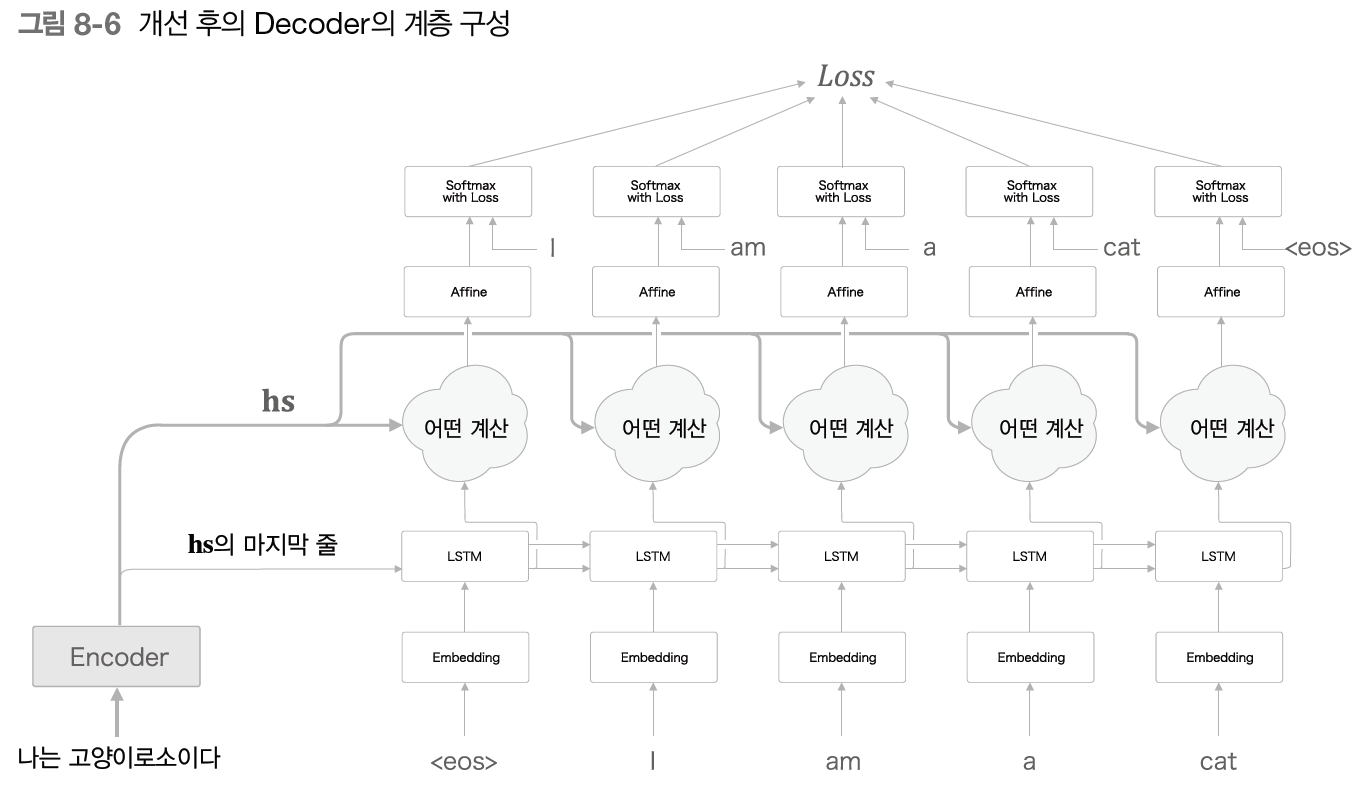

In [4]:
Image("image/fig 8-6.png")

#### 각 단어에 대해서 그것이 얼마나 중요한지를 나타내는 '가중치'

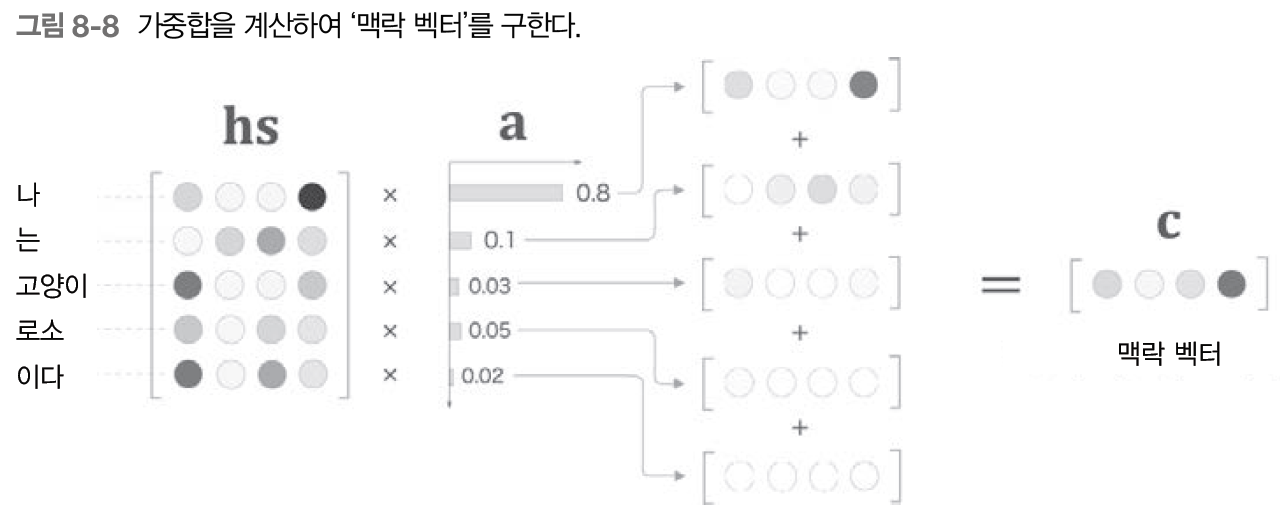

In [5]:
Image("image/fig 8-8.png")

**맥락벡터 c에는 현 시각의 변환을 수행하는데 필요한 정보가 담겨있음!**

In [6]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Softmax


class WeightSum:
    
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1)#.repeat(T, axis=1)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da


### 8.1.4 Decoder 개선 ②

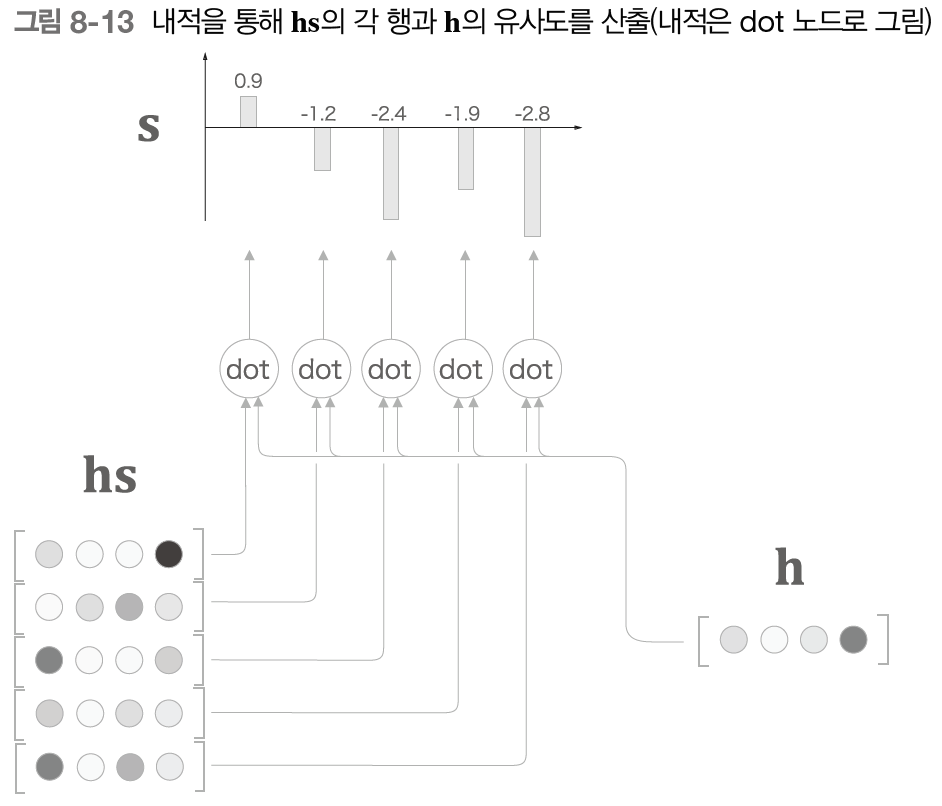

In [7]:
Image("image/fig 8-13.png")

**벡터의 내적을 이용해 h와 hs의 각 단어 벡터와의 유사도를 구하고 softmax를 적용해 정규화한다!**

In [8]:
class AttentionWeight:
    
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

### 8.1.5 Decoder 개선 ③

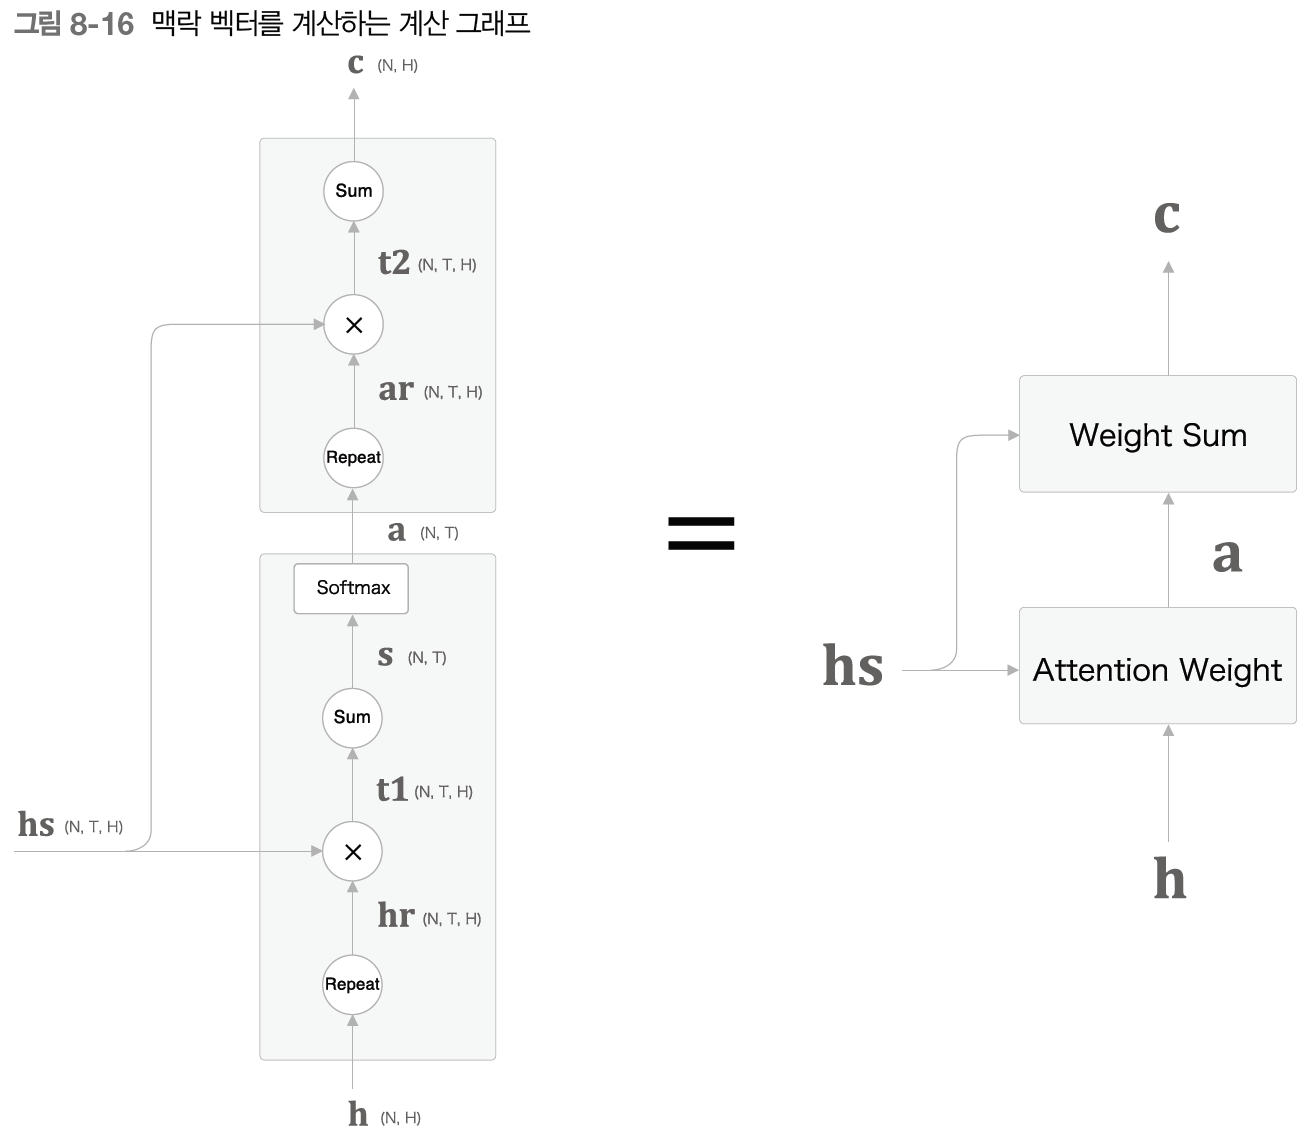

In [9]:
Image("image/fig 8-16.png")

- **Attention 계층** -> **Weight Sum** 계층과 **Attention Weight** 계층 2개로 나눠 구현
- **Attention Weight 계층**: Encoder가 출력하는 각 단어의 벡터 hs에 주목하여 해당 단어의 가중치 a를 구함
- **Weight Sum 계층**: a와 hs의 가중합을 구하고 그 결과를 맥락 벡터 c로 출력

In [10]:
class Attention:
    
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

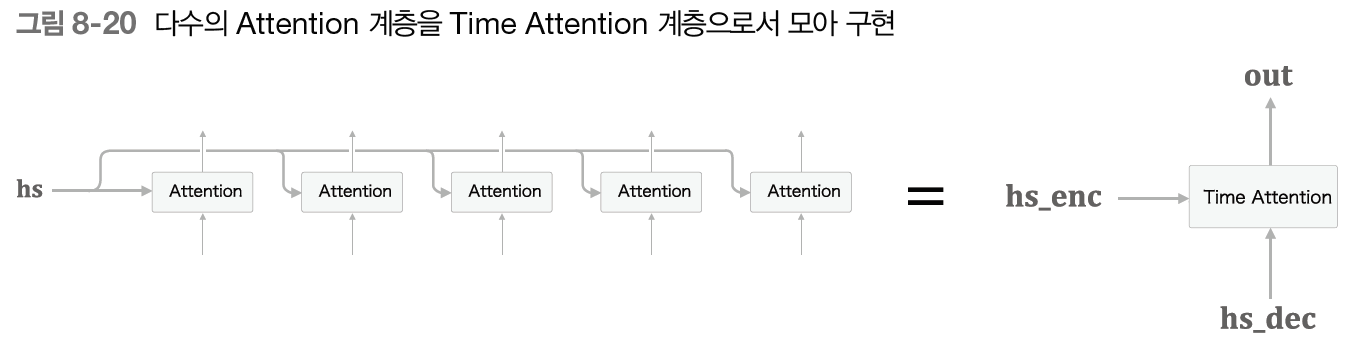

In [11]:
Image("image/fig 8-20.png")

In [12]:
class TimeAttention:
    
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

## 8.2 어텐션을 갖춘 seq2seq 구현

### 8.2.1 Encoder 구현

In [14]:
import sys
sys.path.append('..')
from common.time_layers import *
from seq2seq import Encoder, Seq2seq
from attention_layer import TimeAttention


class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


### 8.2.2 Decoder 구현

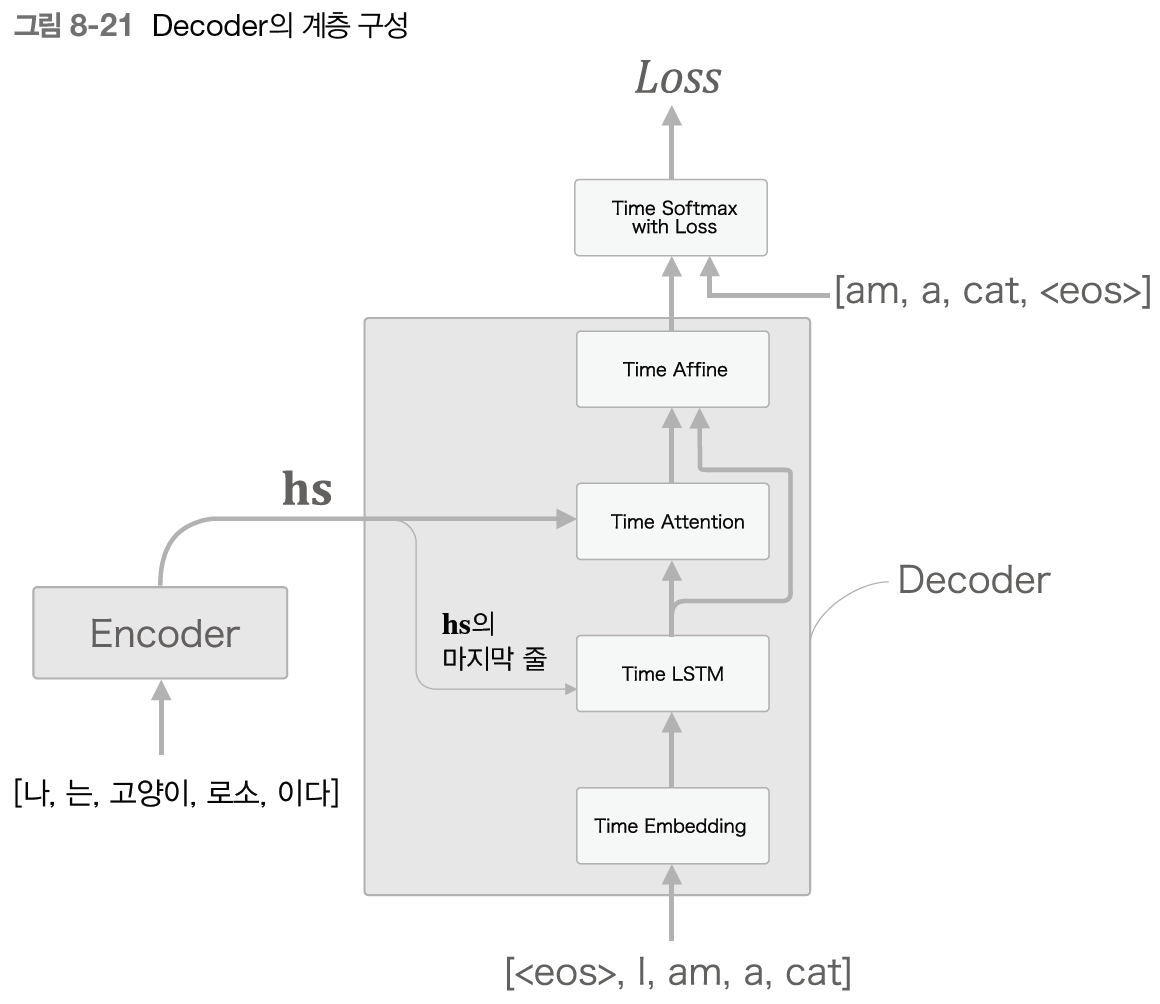

In [16]:
Image("image/fig 8-21.png")

In [17]:
class AttentionDecoder:
    
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled


### 8.2.3 seq2seq 구현

In [18]:
class AttentionSeq2seq(Seq2seq):
    
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## 8.3 어텐션 평가

### 8.3.1 날짜 형식 변환 문제

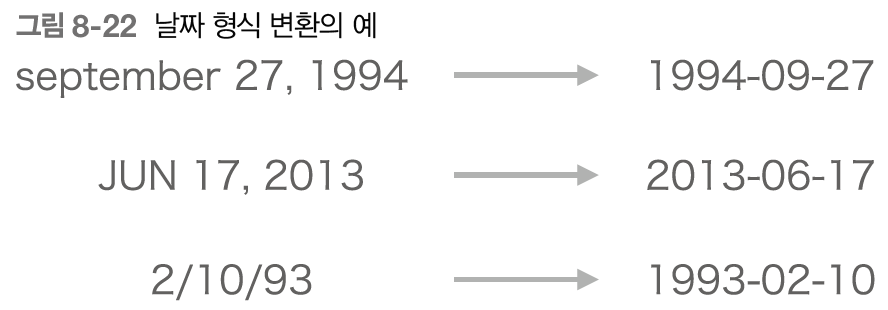

In [19]:
Image("image/fig 8-22.png")

### 8.3.2 어텐션을 갖춘 seq2seq의 학습

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 6[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 11[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 16[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 22[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 27[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 33[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 39[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 44[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 50[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 56[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 61[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 68[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 73[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 79[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 85[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 91[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 97[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1978-08-11
---
Q Tuesday, November 22, 2016  

/Users/ojoo/opt/anaconda3/envs/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ojoo/opt/anaconda3/envs/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ojoo/opt/anaconda3/envs/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ojoo/opt/anaconda3/envs/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ojoo/opt/anaconda3/envs/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ojoo/opt/anac

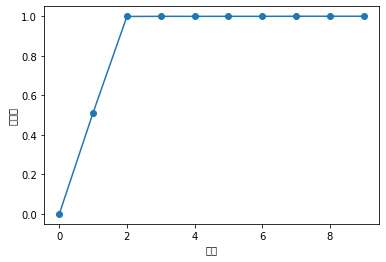

In [25]:
import sys
sys.path.append('.')
import numpy as np
import matplotlib.pyplot as plt
import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
#from attention_seq2seq import AttentionSeq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


model.save_params()

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()